In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torchmetrics.classification.accuracy
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
%matplotlib inline

# начнем нашу работу с данными:
1. Проверим распредееление данных по персонажам, если оно слишком неравномерное -> придется делать аугментацию
2. "Трансформируем" наши данные в тензоры 
3. Нормализуем их -> нам не надо беспокоиться о выбросах 

In [2]:
# "константы" с которыми будут работать наши классы и функции
data_path = "data/simpsons_dataset"
bs = 128
loss_list_train = []
loss_list_test = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
#узнаем, сколько у нас вообще изображений и посмотри на распределение 

persons= {}

# Проходим по всем папкам в директории
for root, dirs, files in os.walk(data_path):
    folder_name = os.path.basename(root)
    if folder_name  == "simpsons_dataset":
        continue
    
    file_count = len(files)
    persons[folder_name] = file_count

cnt = 0
for name in persons.keys():
    cnt += persons[name]
    
print("Всего изоражений:", cnt)    
persons

Всего изоражений: 20933


{'abraham_grampa_simpson': 913,
 'agnes_skinner': 42,
 'apu_nahasapeemapetilon': 623,
 'barney_gumble': 106,
 'bart_simpson': 1342,
 'carl_carlson': 98,
 'charles_montgomery_burns': 1193,
 'chief_wiggum': 986,
 'cletus_spuckler': 47,
 'comic_book_guy': 469,
 'disco_stu': 8,
 'edna_krabappel': 457,
 'fat_tony': 27,
 'gil': 27,
 'groundskeeper_willie': 121,
 'homer_simpson': 2246,
 'kent_brockman': 498,
 'krusty_the_clown': 1206,
 'lenny_leonard': 310,
 'lionel_hutz': 3,
 'lisa_simpson': 1354,
 'maggie_simpson': 128,
 'marge_simpson': 1291,
 'martin_prince': 71,
 'mayor_quimby': 246,
 'milhouse_van_houten': 1079,
 'miss_hoover': 17,
 'moe_szyslak': 1452,
 'ned_flanders': 1454,
 'nelson_muntz': 358,
 'otto_mann': 32,
 'patty_bouvier': 72,
 'principal_skinner': 1194,
 'professor_john_frink': 65,
 'rainier_wolfcastle': 45,
 'ralph_wiggum': 89,
 'selma_bouvier': 103,
 'sideshow_bob': 877,
 'sideshow_mel': 40,
 'snake_jailbird': 55,
 'troy_mcclure': 8,
 'waylon_smithers': 181}

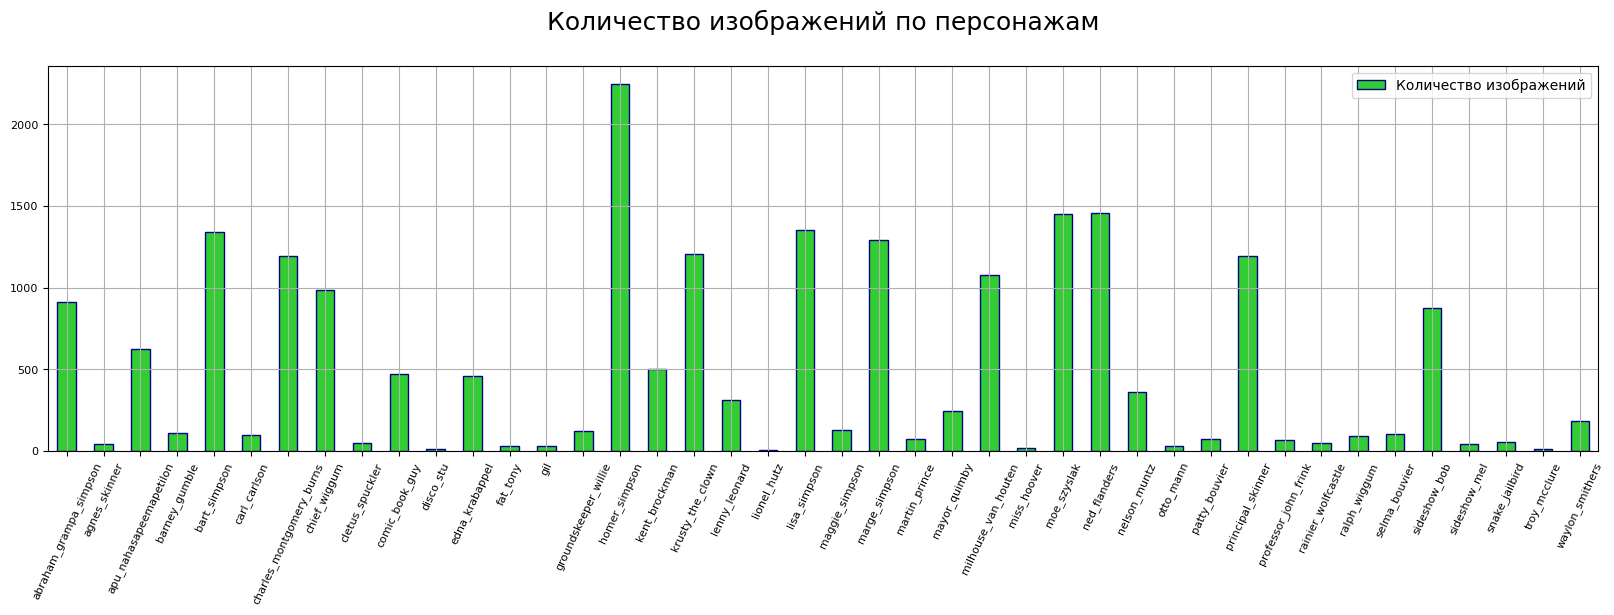

In [4]:
df = pd.DataFrame(persons.values(), persons.keys())
df.columns = ['Количество изображений']
plot = df.plot.bar(
    figsize=(20, 5), fontsize=8, color='limegreen', 
    edgecolor='darkblue', linewidth=1, title='Количество изображений по персонажам\n')
plot.title.set_size(18)
plot.legend(loc=1, fontsize=10)
plot.set(ylabel=None, xlabel=None)
plot.grid()
plt.xticks(rotation=65)
plt.show()

### Видим, что у нас сильный дизбаланс классов: где-то изображений 2000, а где-то и 10 нет => придется делать аугментацию

In [5]:
def get_class_counts(dataset):
    class_counts = torch.zeros(len(persons.keys()), 1)
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

In [6]:
#по сути этот шаг(аугментация) включает в себя и трансформацию в тензоры, и нормализацию данных)
#создадим класс, который подготовит наши данные для обучения и теста
class Dataset_prep():
    """
    класс, который подготовит наш датасет к обучению: 
    он разобьет наши данные на train, val и test, переведет изображения в тезоры и нормализует их
    """   
    #инициализируем наш класс, т.е. передадим ему данные, с которыми он будет рабоать  
    def __init__(self,path):
        super().__init__()
        self.dataset = ImageFolder(path, transform=self.create_transformer())
        
    #создаем трансформер, который переводит изображения в тензоры и нормализует их    
    def create_transformer(self):
        transformer = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.ConvertImageDtype(dtype=torch.float32),
                                  transforms.Resize([100, 100]),
                                  transforms.Normalize(mean=[0.5], std=[0.25])])
        return transformer
    

    def split_and_transform(self):
        labels = [label for _, label in self.dataset]

        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(train_size=0.8, random_state=42)

        train_test_indices, val_indices = next(sss.split(self.dataset, labels))
        train_test_data = [self.dataset[i] for i in train_test_indices]
        val_data = [self.dataset[i] for i in val_indices]

        sss_train = StratifiedShuffleSplit(train_size=0.75, random_state=42)
        train_indices, test_indices = next(sss_train.split(train_test_data, [label for _, label in train_test_data]))
        train_data = [train_test_data[i] for i in train_indices]
        test_data = [train_test_data[i] for i in test_indices]

        return train_data, val_data, test_data

In [7]:
preporations = Dataset_prep(data_path)
train,val,test = preporations.split_and_transform()
print("Теперь train содержит: ",len(train),"val: ",len(val)," и test:",len(test),".В общем мы имеем ",  len(train)+len(val)+len(test),"изображений") 

Теперь train содержит:  12559 val:  4187  и test: 4187 .В общем мы имеем  20933 изображений


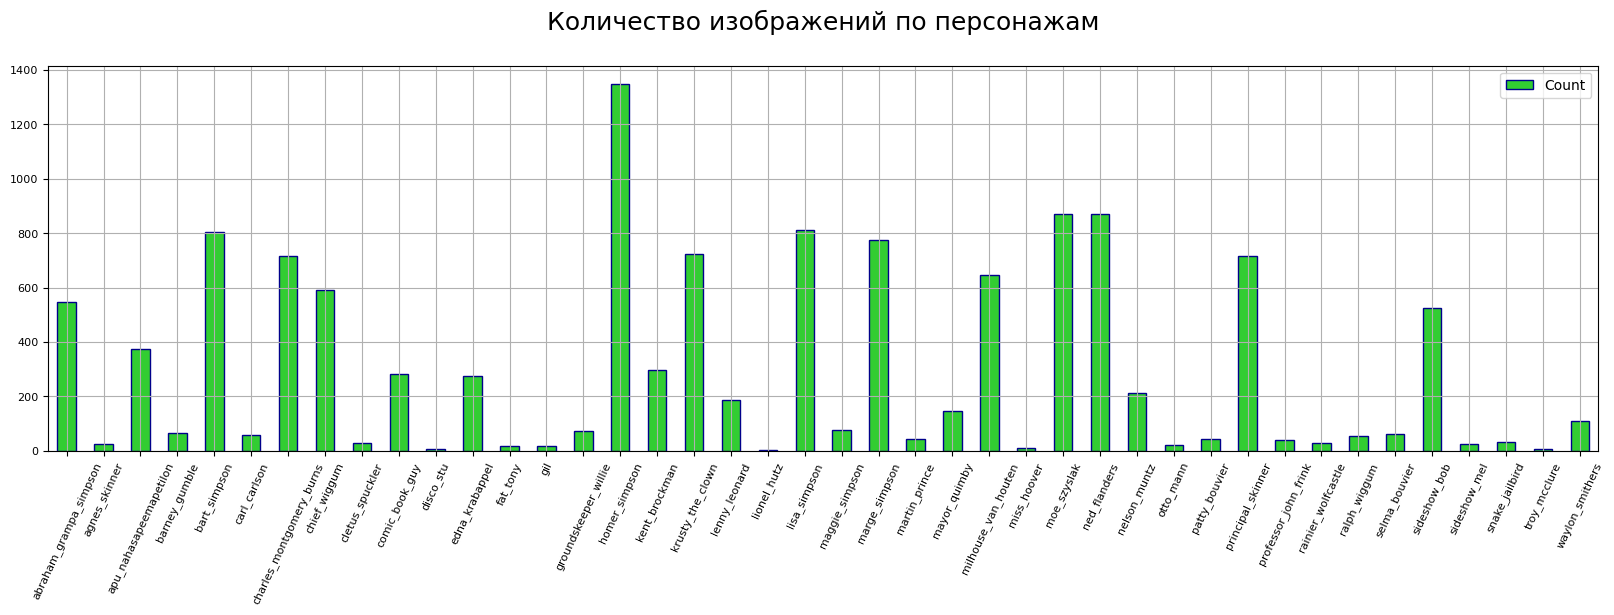

In [8]:
classes = persons.keys()  # Замените классами вашего набора данных

# Подсчитываем количество изображений по классам
class_counts = [0] * len(classes)
for data in train:
    class_counts[data[1]] += 1

# Создаем DataFrame с данными о распределении
df = pd.DataFrame({'Class': classes, 'Count': class_counts}, persons.keys())


plot = df.plot.bar(
    figsize=(20, 5), fontsize=8, color='limegreen', edgecolor='darkblue', linewidth=1, 
    title='Количество изображений по персонажам\n')
plot.title.set_size(18)
plot.legend(loc=1, fontsize=10)
plot.set(ylabel=None, xlabel=None)
plot.grid()
plt.xticks(rotation=65)
plt.show()

In [9]:
target_count=500
augmented_dataset = []
class_counts = get_class_counts(train)

for image, label in train:
    if class_counts[label] <= target_count:
        while class_counts[label] <= target_count:
            augmented_dataset.append((image, label))
    
            if random.randint(0, 1) == 0:
                image = transforms.functional.hflip(image)
               

            if random.randint(0, 1) == 0:
                image = transforms.functional.vflip(image)
               
            if random.randint(0, 1) == 0:
                angle = random.randint(-40, 40)
                image = transforms.functional.rotate(image, angle)
            
            class_counts[label] += 1
    else:
        augmented_dataset.append((image, label))

train = augmented_dataset

aug_class_counts = get_class_counts(train)

aug_class_counts

tensor([[ 547.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 805.],
        [ 500.],
        [ 715.],
        [ 592.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 500.],
        [1348.],
        [ 500.],
        [ 724.],
        [ 500.],
        [ 500.],
        [ 812.],
        [ 500.],
        [ 775.],
        [ 500.],
        [ 500.],
        [ 647.],
        [ 500.],
        [ 871.],
        [ 872.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 716.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 526.],
        [ 500.],
        [ 500.],
        [ 500.],
        [ 500.]])

In [10]:
get_class_counts(test)

tensor([[183.],
        [  8.],
        [125.],
        [ 21.],
        [269.],
        [ 20.],
        [239.],
        [197.],
        [  9.],
        [ 94.],
        [  1.],
        [ 92.],
        [  5.],
        [  5.],
        [ 24.],
        [449.],
        [100.],
        [241.],
        [ 62.],
        [  0.],
        [271.],
        [ 26.],
        [258.],
        [ 14.],
        [ 49.],
        [216.],
        [  3.],
        [290.],
        [291.],
        [ 72.],
        [  6.],
        [ 15.],
        [239.],
        [ 13.],
        [  9.],
        [ 18.],
        [ 21.],
        [176.],
        [  8.],
        [ 11.],
        [  1.],
        [ 36.]])

In [11]:
train_loader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True)
val_loader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=bs, shuffle=True)
print("Теперь train содержит: ",len(train),"val: ",len(val)," и test:",len(test),".В общем мы имеем ",  len(train)+len(val)+len(test),"изображений") 

Теперь train содержит:  24450 val:  4187  и test: 4187 .В общем мы имеем  32824 изображений


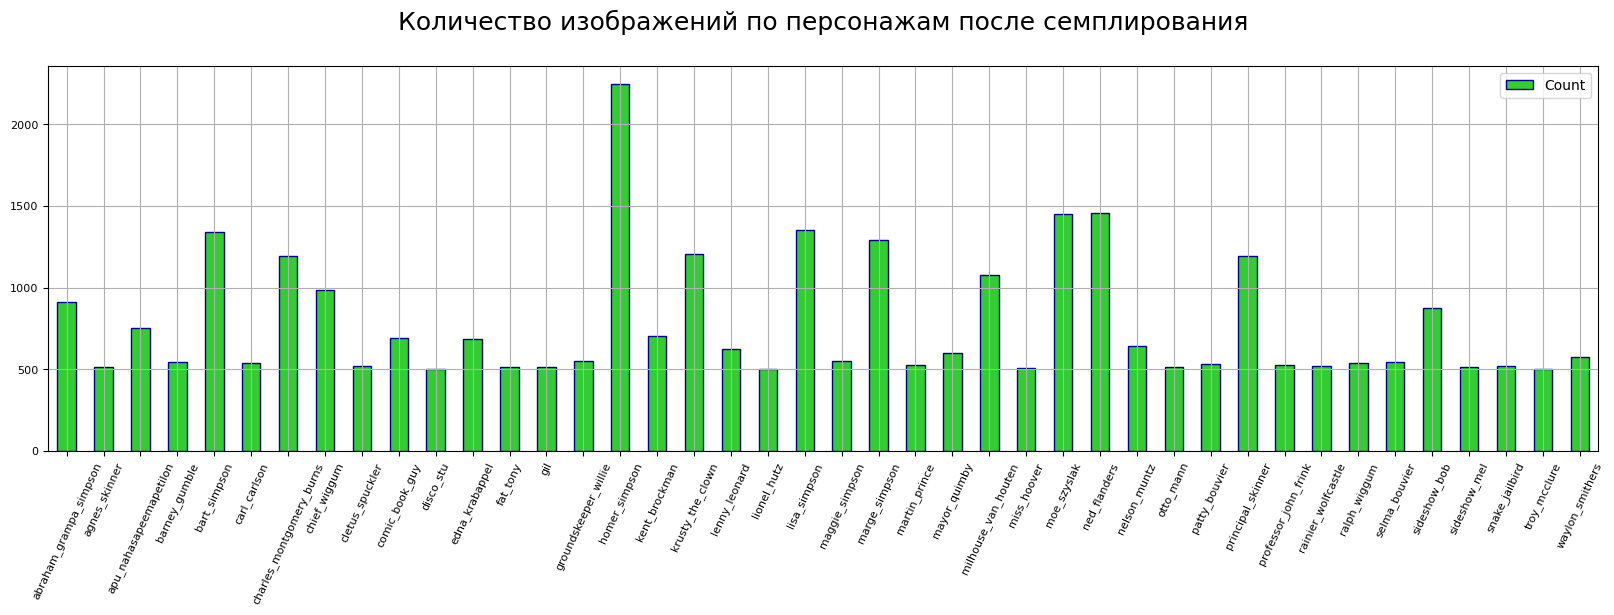

In [12]:
all_data = torch.utils.data.ConcatDataset([train, val, test])

# Создаем список классов
classes = persons.keys()  # Замените классами вашего набора данных

# Подсчитываем количество изображений по классам
class_counts = [0] * len(classes)
for data in all_data:
    class_counts[data[1]] += 1

# Создаем DataFrame с данными о распределении
df = pd.DataFrame({'Class': classes, 'Count': class_counts}, persons.keys())


plot = df.plot.bar(
    figsize=(20, 5), fontsize=8, color='limegreen', edgecolor='darkblue', linewidth=1, 
    title='Количество изображений по персонажам после семплирования\n')
plot.title.set_size(18)
plot.legend(loc=1, fontsize=10)
plot.set(ylabel=None, xlabel=None)
plot.grid()
plt.xticks(rotation=65)
plt.show()

### Видим, что теперь распределение наших данных нормализовалось. Можем приступать к обучению
для обучения нам нужно: 
1. Определить модель(будем использовать сверточную сеть, потому что мы будем классифицировать изоражения)
2. Определимся с los функцией 
3. Определим веса 
4. Обучим модель
5. Протестируем модель на test и подведем итоги

In [13]:
class Conv_neural_net(nn.Module):
    def __init__(self, num_classes):
        super(Conv_neural_net, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 25 * 25, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [14]:
# определим веса, используя подход Inverse class frequency weighting. Согласно этого мы присвоим больший вес классам, который встречается реже
all_data_loader = torch.utils.data.DataLoader(all_data, batch_size=bs, shuffle=True)

class_counts = torch.zeros(42)
for _, labels in all_data_loader:
    class_counts += torch.bincount(labels, minlength=42)

# Вычисление весов классов
total_samples = class_counts.sum()
class_weights = total_samples / (42 * class_counts)
class_weights = torch.Tensor(class_weights).to(device)

In [15]:
#определим остальные параметры обучения и инициализируем модель
from torchmetrics.classification import MulticlassStatScores

stats = MulticlassStatScores(num_classes=42, average=None).to(device) 
model = Conv_neural_net(42)
model.to(device)  
loss_func = nn.CrossEntropyLoss(weight = class_weights)   
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

 ### Наконец мы можем приступать к обучению

In [16]:
def calculate_loss(target, labels, loss_func, mode="train"):
    loss = loss_func(target, labels)
    loss_temp = loss
    if mode == "train":
        loss_list_train.append(loss_temp.item())
    else:
        loss_list_test.append(loss_temp.item())
    return loss

In [17]:
from tqdm import tqdm

for i in range(30):
    for data, labels in tqdm(train_loader):
        model.train()  
        data, labels = data.to(device), labels.to(device)  
        optimizer.zero_grad()  
        target = model(data)  
        loss = calculate_loss(target, labels, loss_func)
        
        loss.backward()
        optimizer.step()

    for data, labels in tqdm(test_loader):
        model.eval()  
        data, labels = data.to(device), labels.to(device)
        target = model(data)
        calculate_loss(target, labels, loss_func, mode="test")

100%|██████████| 33/33 [00:00<00:00, 185.35it/s]


In [18]:
class_acc = 0

for data, labels in test_loader:
    model.eval()
    data, labels = data.to(device), labels.to(device)
    target = model(data)    
    stats.update(target, labels)
    
tp, fp, tn, fn = stats._final_state() 
tp, fp, tn, fn = tp.cpu(), fp.cpu(), tn.cpu(), fn.cpu()
class_acc = torch.nan_to_num(torch.div(tp+tn, tp+fp+tn+fn))
    
class_acc

tensor([0.9721, 0.9974, 0.9890, 0.9945, 0.9429, 0.9967, 0.9532, 0.9735, 0.9971,
        0.9854, 0.9998, 0.9864, 0.9998, 0.9995, 0.9957, 0.9214, 0.9916, 0.9787,
        0.9881, 1.0000, 0.9386, 0.9928, 0.9771, 0.9976, 0.9924, 0.9730, 0.9990,
        0.9553, 0.9596, 0.9833, 0.9983, 0.9971, 0.9663, 0.9964, 0.9979, 0.9967,
        0.9959, 0.9785, 0.9983, 0.9981, 0.9995, 0.9933])

In [19]:
class_rec = torch.nan_to_num(torch.div(tp, tp+fn))
class_rec

tensor([0.7213, 0.0000, 0.8400, 0.2381, 0.5651, 0.5500, 0.5649, 0.7462, 0.2222,
        0.5638, 0.0000, 0.6848, 0.8000, 0.6000, 0.3750, 0.6882, 0.8000, 0.8423,
        0.4839, 0.0000, 0.5314, 0.1923, 0.8178, 0.4286, 0.5714, 0.7500, 0.0000,
        0.7345, 0.6942, 0.5833, 0.3333, 0.3333, 0.7490, 0.2308, 0.3333, 0.4444,
        0.5238, 0.7614, 0.2500, 0.3636, 1.0000, 0.3889])

In [20]:
class_pres = torch.nan_to_num(torch.div(tp, tp+fp))
    
class_pres

tensor([0.6667, 0.0000, 0.8015, 0.4167, 0.5547, 0.6875, 0.5947, 0.7067, 0.2857,
        0.7260, 0.0000, 0.6923, 1.0000, 1.0000, 0.7500, 0.6205, 0.8421, 0.7992,
        0.6250, 0.0000, 0.5255, 0.3571, 0.8115, 0.7500, 0.7179, 0.7330, 0.0000,
        0.6594, 0.7163, 0.5122, 0.4000, 0.7143, 0.6885, 0.3750, 0.5000, 0.6667,
        0.6111, 0.7363, 0.6667, 0.8000, 0.3333, 0.7000])

In [21]:
class_f1 = torch.nan_to_num(torch.div(2 *(class_pres * class_rec) , class_pres + class_rec))
class_f1

tensor([0.6929, 0.0000, 0.8203, 0.3030, 0.5599, 0.6111, 0.5794, 0.7259, 0.2500,
        0.6347, 0.0000, 0.6885, 0.8889, 0.7500, 0.5000, 0.6526, 0.8205, 0.8202,
        0.5455, 0.0000, 0.5284, 0.2500, 0.8147, 0.5455, 0.6364, 0.7414, 0.0000,
        0.6949, 0.7051, 0.5455, 0.3636, 0.4545, 0.7174, 0.2857, 0.4000, 0.5333,
        0.5641, 0.7486, 0.3636, 0.5000, 0.5000, 0.5000])

### Видим, что у нас плохой скор там, где в тесте крайне мало данных

## ИТОГ: Для обучения нейросети, которая классифицирует изображения симпсонов, я сделал следующие: 
1. Изучил распределение изображений по классам
2. Нормализовал данные и разбил dataset на train,val и test
3. Провел аугментацию данных для train части
4. Создал сверточную нейросеть(тк мы классифицируем изображения)
5. Обучил её и измерили разные метрики